In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [21]:
df = pd.read_excel('C:/Lohit/New folder/starbucks_order_data.xlsx')

df.head()

,Employee_ID,Order_Time,Order_Size,Order_Type,Order_Status,Day_of_Week,Order_Hour
0,1,2025-03-05 06:00:00,4,Mocha,Completed,2,6
1,2,2025-03-03 23:00:00,1,Mocha,Completed,0,23
2,3,2025-03-20 10:00:00,3,Cappuccino,Completed,3,10
3,4,2025-03-16 12:00:00,4,Cappuccino,Pending,6,12
4,5,2025-03-15 07:00:00,4,Latte,Completed,5,7


In [22]:
df.isnull().sum()

Employee_ID     0
Order_Time      0
Order_Size      0
Order_Type      0
Order_Status    0
Day_of_Week     0
Order_Hour      0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Employee_ID   10000 non-null  int64         
 1   Order_Time    10000 non-null  datetime64[ns]
 2   Order_Size    10000 non-null  int64         
 3   Order_Type    10000 non-null  object        
 4   Order_Status  10000 non-null  object        
 5   Day_of_Week   10000 non-null  int64         
 6   Order_Hour    10000 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 547.0+ KB


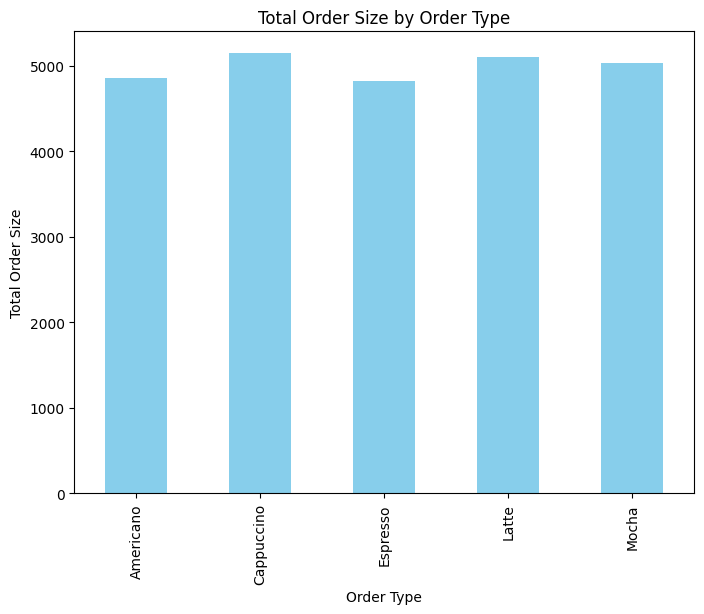

In [24]:
# Group by Order_Type and sum the Order_Size
order_type_data = df.groupby('Order_Type')['Order_Size'].sum()

# Create the bar plot
order_type_data.plot(kind='bar', color='skyblue', figsize=(8, 6))
plt.title("Total Order Size by Order Type")
plt.xlabel("Order Type")
plt.ylabel("Total Order Size")
plt.show()

C:\Users\lohit\AppData\Local\Temp\ipykernel_55380\4287842479.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Order_Status', data=df, palette='coolwarm')


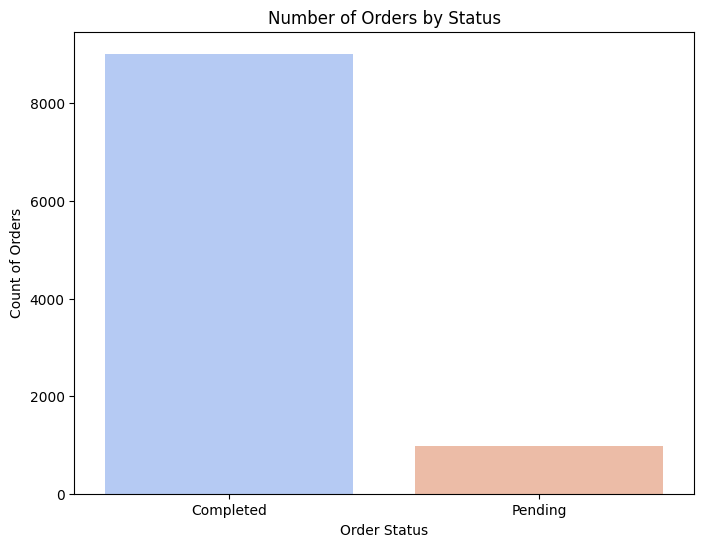

In [25]:
# Create a count plot for Order_Status
plt.figure(figsize=(8, 6))
sns.countplot(x='Order_Status', data=df, palette='coolwarm')
plt.title("Number of Orders by Status")
plt.xlabel("Order Status")
plt.ylabel("Count of Orders")
plt.show()

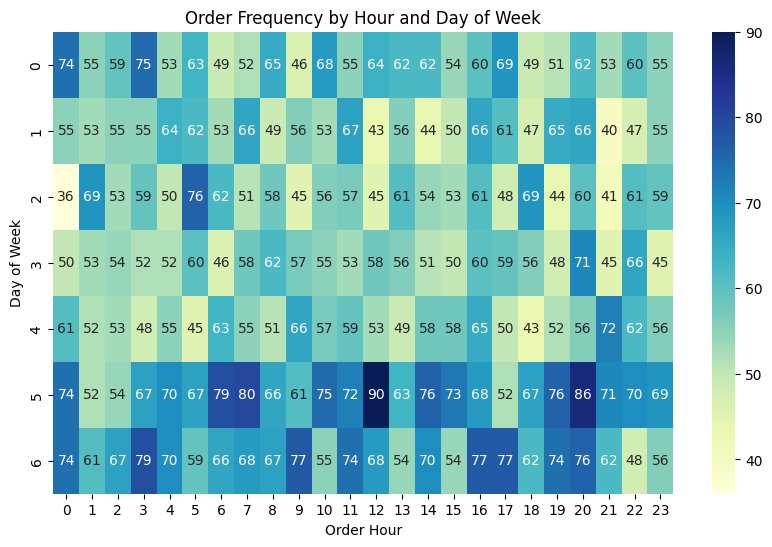

In [26]:
# Pivot the data to get the frequency of orders
heatmap_data = df.pivot_table(index='Day_of_Week', columns='Order_Hour', aggfunc='size', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title("Order Frequency by Hour and Day of Week")
plt.xlabel("Order Hour")
plt.ylabel("Day of Week")
plt.show()

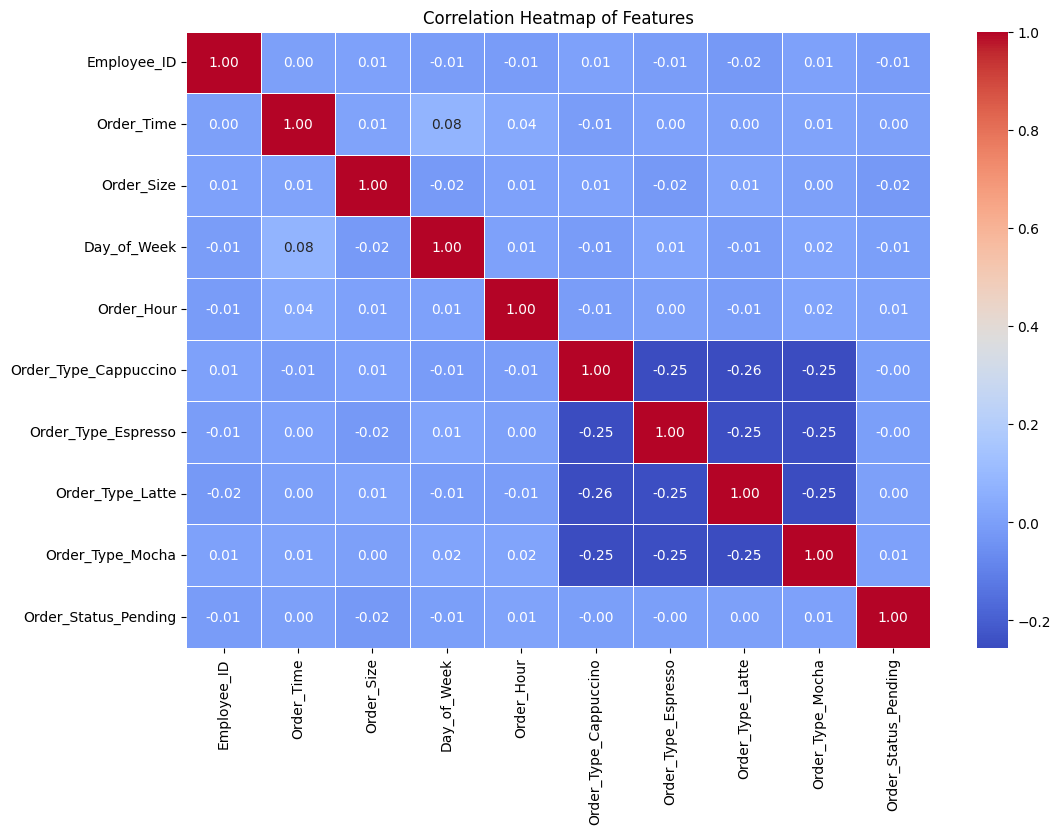

In [27]:
# One-hot encode categorical columns (Order_Type and Order_Status)
df_encoded = pd.get_dummies(df, columns=['Order_Type', 'Order_Status'], drop_first=True)

# Calculate the correlation matrix for numeric columns
corr_matrix = df_encoded.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [28]:
# Aggregating the data to get total number of orders per hour and day of the week
order_data_grouped = df.groupby(['Order_Hour', 'Day_of_Week']).size().reset_index(name='Order_Count')

# Split the data into features (X) and target (y)
X = order_data_grouped[['Order_Hour', 'Day_of_Week']]
y = order_data_grouped['Order_Count']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple linear regression model to predict demand
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
mae

8.30033881341164

In [29]:
# Constants for the simulation
service_time_per_drink = 2  # Estimated time to serve one drink in minutes 
avg_drinks_per_order = df['Order_Size'].mean()

# Predicted demand: Generate demand predictions based on Order Hour and Day of Week
order_data_grouped['Predicted_Order_Count'] = model.predict(order_data_grouped[['Order_Hour', 'Day_of_Week']])

# Simulate queueing behavior for a sample time period (e.g., a specific hour of the day, say 9 AM)
sample_hour = 9
demand_for_sample_hour = order_data_grouped[order_data_grouped['Order_Hour'] == sample_hour]['Predicted_Order_Count'].values[0]

# Assume each order has an average number of drinks as estimated earlier
avg_service_time = avg_drinks_per_order * service_time_per_drink  # in minutes

# Now, calculate the required number of baristas (servers) using the queueing model
def mmc_queueing(demand, service_time, num_servers):
    """
    Function to calculate average wait time and queue length in an M/M/c queue model.
    
    demand: total number of orders (demand for that hour).
    service_time: time taken to process each order (in minutes).
    num_servers: number of servers (baristas).
    """
    arrival_rate = demand / 60  # Orders per minute
    service_rate = 1 / service_time  # Orders served per minute

    # Traffic intensity (utilization factor)
    rho = arrival_rate / (num_servers * service_rate)

    if rho >= 1:
        # If the system is overloaded (too many arrivals for the number of servers), wait times will increase dramatically
        return "Overloaded", "Overloaded"
    
    # Calculate average number of people in the system (L) and average wait time in the queue (Wq)
    L = rho * num_servers / (1 - rho)
    Wq = L / arrival_rate  # Average wait time in the queue

    return L, Wq

# Try different number of baristas to find optimal staffing
optimal_servers = 1
min_wait_time = float('inf')

# Test with 1 to 10 baristas
for num_servers in range(1, 11):
    _, wait_time = mmc_queueing(demand_for_sample_hour, avg_service_time, num_servers)
    
    if wait_time != "Overloaded" and wait_time < min_wait_time:
        min_wait_time = wait_time
        optimal_servers = num_servers

optimal_servers, min_wait_time


(10, np.float64(9.08113193509378))

In [30]:
# Initialize a list to store staffing recommendations for each hour of the day
staffing_schedule = []

# Simulate for each hour of the day (0 to 23)
for hour in range(24):
    # Get the predicted demand for the current hour
    demand_for_hour = order_data_grouped[order_data_grouped['Order_Hour'] == hour]['Predicted_Order_Count'].values[0]

    # Try different number of baristas to find optimal staffing for the current hour
    optimal_servers = 1
    min_wait_time = float('inf')

    for num_servers in range(1, 11):
        _, wait_time = mmc_queueing(demand_for_hour, avg_service_time, num_servers)
        
        if wait_time != "Overloaded" and wait_time < min_wait_time:
            min_wait_time = wait_time
            optimal_servers = num_servers
    
    staffing_schedule.append((hour, optimal_servers, min_wait_time))

# Convert the staffing schedule into a DataFrame
staffing_df = pd.DataFrame(staffing_schedule, columns=["Hour", "Optimal_Baristas", "Avg_Wait_Time"])

staffing_df.head()

,Hour,Optimal_Baristas,Avg_Wait_Time
0,0,10,9.145945
1,1,10,9.138698
2,2,10,9.131463
3,3,10,9.124238
4,4,10,9.117026


In [32]:
staffing_df

,Hour,Optimal_Baristas,Avg_Wait_Time
0,0,10,9.145945
1,1,10,9.138698
2,2,10,9.131463
3,3,10,9.124238
4,4,10,9.117026
5,5,10,9.109824
6,6,10,9.102634
7,7,10,9.095455
8,8,10,9.088288
9,9,10,9.081132
